<a href="https://colab.research.google.com/github/nihalaltay/turkish-spanish-city-name-generator-LM/blob/main/NLP_A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
#---*-**-*--- Spanish City Name Generator Model ---*-**-*---#

# Form the dataset: Get Spanish city names

# Direct download link
download_url = 'https://drive.google.com/uc?export=download&id=111bav2EnTulNFfWTskyGbUzkAUwkbW9g'

# Load the CSV file (dfs: dataframe spain)
dfs = pd.read_csv(download_url)

# Preview the first few rows
# print(dfs.head())

# Check the column names to identify which one contains the city names
print("\nColumn Names:")
print(dfs.columns)

# Keep only the city names column and drop others
dfs_clean = dfs[['name']]

# Remove duplicates and any leading/trailing spaces
dfs_clean['name'] = dfs_clean['name'].str.strip()
dfs_clean = dfs_clean.drop_duplicates()

# Display cleaned data
print("\nCleaned DataFrame:")
print(dfs_clean.head())


Column Names:
Index(['code', 'postal_code', 'name', 'phone_code', 'iso2'], dtype='object')

Cleaned DataFrame:
       name
0     Álava
1  Albacete
2   Alacant
3   Almería
4     Ávila


<ipython-input-2-484e2cd329ec>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_clean['name'] = dfs_clean['name'].str.strip()


In [3]:
# Process the dataset. Make it into a list. Remove dots too, because they conflict with dots marking the end of teh words, hindering the training.
es_cities = dfs['name'].dropna().str.lower().str.replace('.', '', regex=False).tolist()

# Preview the first few elements
print(es_cities[:10])

['álava', 'albacete', 'alacant', 'almería', 'ávila', 'badajoz', 'illes balears', 'barcelona', 'burgos', 'cáceres']


In [4]:
len(es_cities)

52

In [5]:
# Build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(es_cities))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: ' ', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'z', 24: 'á', 25: 'é', 26: 'í', 27: 'ñ', 28: 'ó', 0: '.'}


In [6]:
# Build the new dataset
block_size = 3 # context length: how many characters do we take to predict the next one.

def build_dataset(es_cities):
  X, Y = [], []
  for w in es_cities:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(es_cities)
n1 = int(0.8*len(es_cities))
n2 = int(0.9*len(es_cities))

Xtr, Ytr = build_dataset(es_cities[:n1])
Xdev, Ydev = build_dataset(es_cities[n1:n2])
Xte, Yte = build_dataset(es_cities[n2:])

torch.Size([340, 3]) torch.Size([340])
torch.Size([49, 3]) torch.Size([49])
torch.Size([50, 3]) torch.Size([50])


In [7]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((29, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 29), generator=g)
b2 = torch.randn(29, generator=g)
parameters = [C, W1, b1, W2, b2]

In [8]:
sum(p.nelement() for p in parameters) # number of parameters in total

12319

In [9]:
for p in parameters:
  p.requires_grad = True

In [10]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [11]:
lri = []
lossi = []
stepi = []

In [12]:
#Training the model

num_iterations = 50000
batch_size = 32

for i in range(num_iterations):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))

  # forward pass
  emb = C[Xtr[ix]] # (batch_size, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (batch_size, hidden_units)
  logits = h @ W2 + b2 # (batch_size, 27)
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # learning rate schedule
  if i < 10000:
    lr = 0.005
  elif i < 30000:
    lr = 0.001
  else:
    lr = 0.0001

  # parameter update
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  stepi.append(i)
  lossi.append(loss.log10().item())

  if i % 5000 == 0:  # Print progress every 5000 steps
    print(f"Iteration {i}, Loss: {loss.item():.4f}")

Iteration 0, Loss: 26.5276
Iteration 5000, Loss: 0.3507
Iteration 10000, Loss: 0.5237
Iteration 15000, Loss: 0.5310
Iteration 20000, Loss: 0.6790
Iteration 25000, Loss: 0.7471
Iteration 30000, Loss: 0.3861
Iteration 35000, Loss: 0.3183
Iteration 40000, Loss: 0.5610
Iteration 45000, Loss: 0.3039


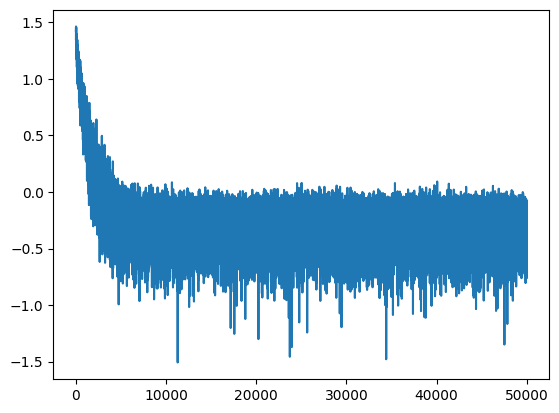

In [13]:
plt.plot(stepi, lossi)

In [14]:
# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(0.5051, grad_fn=<NllLossBackward0>)

In [15]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(14.8398, grad_fn=<NllLossBackward0>)

In [16]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(11.1385, grad_fn=<NllLossBackward0>)

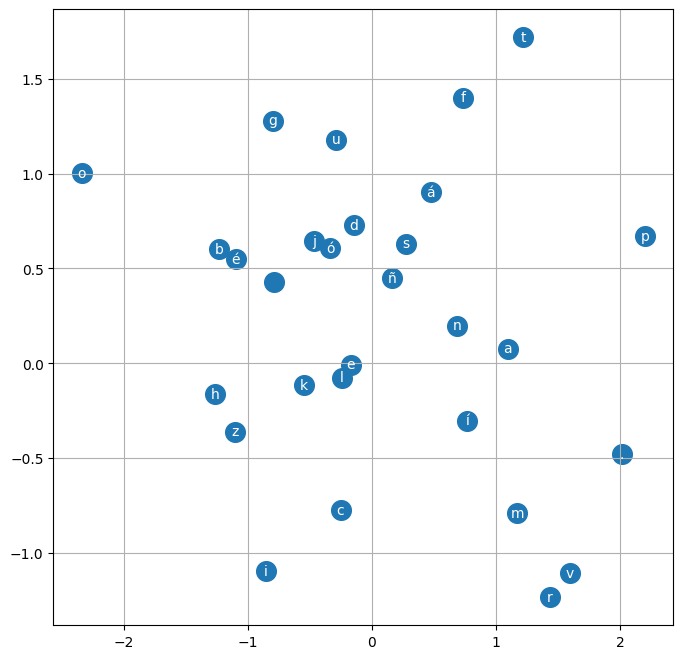

In [17]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [18]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

la rioja.
casturia.
gipuzkoa.
la rioja.
ceuta.
girona.
huelva.
ourense.
valladolid.
astelló.
cansovia.
salamanca.
murcia.
valla.
ourense.
lugo.
lugo.
ávila.
guadalacantabrias.
segovia.


In [19]:
#---*-**-*--- Turkish City Name Generator Model ---*-**-*---#

# Form the dataset: Get Turkish city names

# Direct download link
download_url = 'https://docs.google.com/spreadsheets/d/17P_60-tt8ulF3yVlB3-kJHn1Z7Geqe5q/export?format=csv'

# Load the CSV file (dft: dataframe türkiye)
dft = pd.read_csv(download_url)

# Preview the first few rows
# print(dft.head())

# Check the column names to identify which one contains the city names
print("\nColumn Names:")
print(dft.columns)

# Keep only the city names column and drop others
dft_clean = dft[['İl']]

# Remove duplicates and any leading/trailing spaces
dft_clean['İl'] = dft_clean['İl'].str.strip()
dft_clean = dft_clean.drop_duplicates()

# Display cleaned data
print("\nCleaned DataFrame:")
print(dft_clean.head())


Column Names:
Index(['İl'], dtype='object')

Cleaned DataFrame:
               İl
0           Adana
1        Adıyaman
2  Afyonkarahisar
3            Ağrı
4         Aksaray


In [20]:
# Process the dataset. Make it into a list
tr_cities = dft['İl'].dropna().str.lower().tolist()

# Preview the first few elements
print(tr_cities[:10])

['adana', 'adıyaman', 'afyonkarahisar', 'ağrı', 'aksaray', 'amasya', 'ankara', 'antalya', 'ardahan', 'artvin']


In [21]:
len(tr_cities)

81

In [22]:
# Process the dataset. Make it into a list
tr_cities = dft['İl'].dropna().str.lower().tolist()

# Preview the first few elements
print(tr_cities[:10])

['adana', 'adıyaman', 'afyonkarahisar', 'ağrı', 'aksaray', 'amasya', 'ankara', 'antalya', 'ardahan', 'artvin']


In [23]:
# Build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(tr_cities))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'r', 17: 's', 18: 't', 19: 'u', 20: 'v', 21: 'y', 22: 'z', 23: 'â', 24: 'ç', 25: 'ö', 26: 'ü', 27: 'ğ', 28: 'ı', 29: 'ş', 30: '̇', 0: '.'}


In [24]:
# Build the new dataset
block_size = 3 # context length: how many characters do we take to predict the next one.

def build_dataset(tr_cities):
  X, Y = [], []
  for w in tr_cities:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(tr_cities)
n1 = int(0.8*len(tr_cities))
n2 = int(0.9*len(tr_cities))

Xtr, Ytr = build_dataset(tr_cities[:n1])
Xdev, Ydev = build_dataset(tr_cities[n1:n2])
Xte, Yte = build_dataset(tr_cities[n2:])

torch.Size([492, 3]) torch.Size([492])
torch.Size([59, 3]) torch.Size([59])
torch.Size([68, 3]) torch.Size([68])


In [25]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((33, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 33), generator=g)
b2 = torch.randn(33, generator=g)
parameters = [C, W1, b1, W2, b2]

In [26]:
sum(p.nelement() for p in parameters) # number of parameters in total

13163

In [27]:
for p in parameters:
  p.requires_grad = True

In [28]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [29]:
lri = []
lossi = []
stepi = []

In [30]:
#Training the model

num_iterations = 50000
batch_size = 32

for i in range(num_iterations):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))

  # forward pass
  emb = C[Xtr[ix]] # (batch_size, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (batch_size, hidden_units)
  logits = h @ W2 + b2 # (batch_size, 27)
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # learning rate schedule
  if i < 10000:
    lr = 0.005
  elif i < 30000:
    lr = 0.001
  else:
    lr = 0.0001

  # parameter update
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  stepi.append(i)
  lossi.append(loss.log10().item())

  if i % 5000 == 0:  # Print progress every 5000 steps
    print(f"Iteration {i}, Loss: {loss.item():.4f}")


Iteration 0, Loss: 25.1707
Iteration 5000, Loss: 0.7371
Iteration 10000, Loss: 0.4562
Iteration 15000, Loss: 0.6830
Iteration 20000, Loss: 0.8081
Iteration 25000, Loss: 0.6760
Iteration 30000, Loss: 0.8540
Iteration 35000, Loss: 0.6462
Iteration 40000, Loss: 0.8370
Iteration 45000, Loss: 0.6183


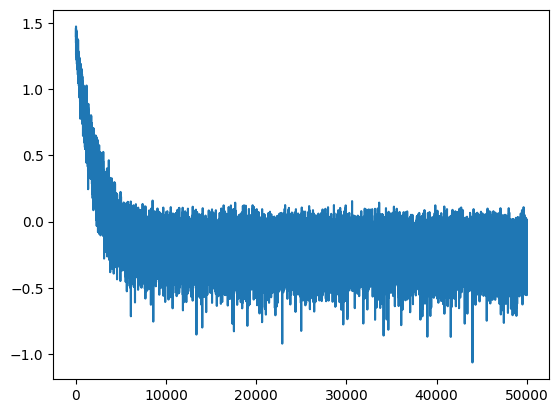

In [31]:
plt.plot(stepi, lossi)

In [32]:
# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(0.6509, grad_fn=<NllLossBackward0>)

In [33]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(12.3787, grad_fn=<NllLossBackward0>)

In [34]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(10.3295, grad_fn=<NllLossBackward0>)

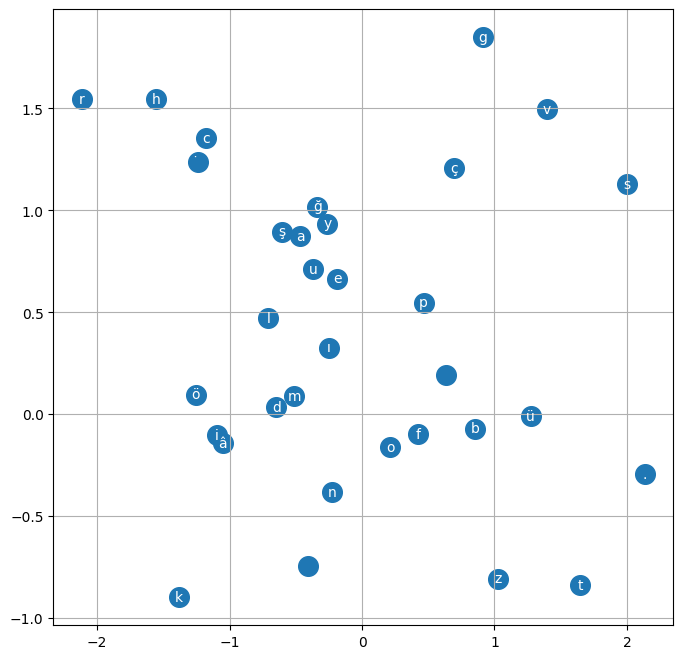

In [37]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(min(C.shape[0], len(itos))):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [38]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

bingöl.
çanakkale.
diyarbakırıkkale.
trabük.
kara.
erzurum.
sar.
karaş.
zonguldak.
van.
sivas.
ordur.
zon.
hatay.
ankara.
kırklareli.
aydın.
giresun.
kastamonu.
adıyamasya.
